In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 50
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 148,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    print("Pretrained model loaded")
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
else:
    print("Loaded empty model")
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon-slayer.

I've had a hard time finding a single character who is the most important to me. I've had so many of the characters I have loved, so many of the people I've loved. It's hard to find a character who is the most important to me.

I've always thought that it's because of the character I've loved that I would do something with it.

But it's true. I have had so many of the characters I have loved, and I've never thought of it that way.

It's true. I


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer)
print("Dataset demo snapshot:")
demo_idx = 0
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    if demo_idx > 0:
        break
    demo_idx += 1

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
        
del demo_idx, has_seen_rp

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors


<d><scn>black<msg>Lo "Oh, do tell!"<|endoftext|><d><scn>bareblur<msg>Br "As for my turn, let me demonstrate."<d><scn>bareblur<msg>m "Once again, he consumed his drink, though his swigs were noticeably slower than before. His resolve was also fading, though not as fast as mine had, as he clearly held the advantage. Was there any way I could still turn this around?"<d><scn>black<msg>Br "There."<d><scn>black<msg
>Br "Now, let me ask you a question: I know you wanted to tell me all the stuff about Reza, but was that the only reason you wanted to meet with me?"<p><msg>c "It was."<d><scn>black<msg>Br "Guess you got more outta this than you asked for, then."<d><scn>bareblur<msg>Br "As for my turn, let me demonstrate."<d><scn>bareblur<msg>m "Once again, he consumed his drink, though his swigs were noticeably slower
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors


msg>c "There. Your... turn."<|endoftext|><p><msg>c "Fight Bryce"<d><scn>pad<msg>m "Bryce barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"<|endoftext|><d><scn>o2<msg>Ad "Really? Maybe we all just share a similar taste."<|endoftext|><d><scn>black<msg>m "The flames weakened and grew smaller until they went out, revealing steamy, appetizing pieces of meat."<|endoftext|><d><sc
n>o2<msg>Ad "Can I ask a question for a change?"<|endoftext|><d><scn>np1n<msg>Br "[player_name], do you remember the first victim? The blood on his muzzle from fighting back was neither yours nor Reza's, but still distinctly human. I thought it was an error, or that our DNA tests weren't compatible."<|endoftext|><p><msg>c "Lastly, there are creatures that are said to be able to shapeshift into human form."<|endoftext|><d><scn>park2<msg>Ry "I don't want to talk


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 148 out of 160 layers.)


Step,Training Loss
54,3.202900
108,2.212400
162,1.969500
216,1.869700
270,1.772000
324,1.681500
378,1.597500
432,1.525900
486,1.431800
540,1.395600


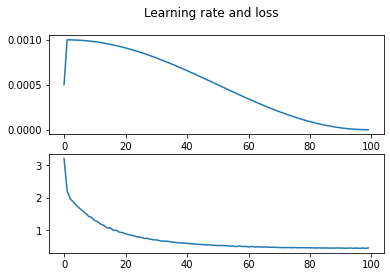

In [9]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [10]:
model.eval()
test_regular_sampler()

In my dreams, I'm a dragon. I bet it was I who found the abandoned building last night in term runs."<|endoftext|>


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [11]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: park2<msg>Ry "I'm not sure, I am not a linguist. Are you?"<d><scn>park2<msg>Ry "No, I'm not sure what's so special about that."<d><scn>park2<msg>Ry "I'm not sure. I do not mean a thing, but I`d rather not. This is an interesting story for


Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "I think you do."<p><msg>c "I was with Lorem in the game long enough to say yes."<d><scn>park2<msg>Ry "..."<d><scn>park2<msg>Ry "..."<d><scn>park2<msg>Ry "..."<d


Prompt: Oh my god, Adine. What is this?
Reply: black<msg>An "It's a long story."<p><msg>c "I can see that."<d><scn>black<msg>An "And have you guys ever held a power plant? That's pretty cool."<d><scn>black<msg>An "I bet you wish I could do that."<|endoftext|>


Prompt: What will we do here?
Reply: loremapt<msg>Lo "I'll have to think about that one for a minute."<p><msg>c "Alright."<p><msg>c "Let's go."<p><msg>c "Let's go."<|endoftext|>




# Sampling test

This is gonna be interesting!

In [12]:
for i in range(10):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "Pretty much, though that is with every new trouble there are."<|endoftext|>

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "Do you think I don't keep asking myself the same questions? What I could've done differently, and if that would've made a difference?"<d><scn>park2<msg>Ry "I don't."<|endoftext|>

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: black<msg>Ad "What are you talking about?"<p><msg>c "I'm not sure if it's my kind of book."<d><scn>black<msg>An "I suppose I read the right kinds of books growing up. I know most of those trick questions."<d><scn>black<msg>An "Thanks."<d><scn>black<

[Test 1] -> Prompt: What will we do here?
Reply: park2<msg>Ry "I'm starting to think thisEditedBy. you?"<d><scn>park2<msg>Ry "That's good to hear. I certainly wouldn't mind if you do."<d><scn>park2<msg>Ry "If I was, I’d never have said it."<|endoftext|>

-------------
[Test 2] -> Prompt: How are you?
Reply: p

# RP test
Testing out the injected roleplay actions

In [13]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')

Visit Lorem -> loremapt<msg>Lo "Hey [player_name]! How are you?"<|endoftext|>
Meet with Lorem -> loremapt<msg>Lo "Hey [player_name]! How are you?"<|endoftext|>
Visit Adine -> adineapt<msg>Ad "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
Fight Maverick -> loremapt<msg>m "Opp then. What's the difference?"<|endoftext|>
Fight Adine -> bare<msg>Ad "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
Attack Adine -> park1<msg>Ka "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
